In [1]:
using QuantumACES, LinearAlgebra, SparseArrays, StatsBase, LsqFit
using Plots, Plots.PlotMeasures, StatsPlots, ColorSchemes, LaTeXStrings
using PrettyTables, Suppressor, JLD2
# Set default plot parameters
@suppress pgfplotsx()
default(grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    legendfonthalign=:left)
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amsmath}")
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amssymb}")
# :tol_bright is a colourblind-friendly colourscheme
tol_bright = ColorSchemes.tol_bright
colour_series = [tol_bright[3]; tol_bright[1]; tol_bright[2]; tol_bright[4]; tol_bright[5]]
# In REVTeX, one column width is 246 pt, and the text width is 510 pt
col_width = 246.0
text_width = 510.0
aspect_ratio = 4 / 3
inches_per_pt = 1.0 / 72.27
default_dpi = 100.0
col_width_px = col_width * inches_per_pt * default_dpi
text_width_px = text_width * inches_per_pt * default_dpi
col_height_px = col_width_px / aspect_ratio
text_height_px = text_width_px / aspect_ratio
triple_height = (1 + 2 * (text_width / col_width - 1)) * col_width / aspect_ratio
triple_height_px = triple_height * inches_per_pt * default_dpi;

In [2]:
# Load the data
memory_summary_coll = load("data/aces_decoding_data.jld2")["memory_summary_coll"]
dist_set = [3; 5; 7; 9; 11; 13]
dist_num = length(dist_set)
rounds_set = [3; 5; 9; 17; 33]
rounds_num = length(rounds_set)
decoder_labels = ["True noise"; "Tuned depolarising"; "ACES: 10^6 shots"; "ACES: 10^7 shots"]
decoder_plot_labels = ["True noise"; "Tuned depolarising"; L"ACES: $10^6$ shots"; L"ACES: $10^7$ shots"]
linestyle_set = [:dot; :solid; :dash; :dashdot]
decoder_num = length(decoder_labels)
@assert decoder_num == length(decoder_plot_labels)
shots = memory_summary_coll[1][1][1].shots
seed_num_set = [1500; 300; 100; 80; 60; 50]
# Check the data
for dist_idx in 1:dist_num
    @assert length(memory_summary_coll[dist_idx]) == seed_num_set[dist_idx]
    for seed_idx in 1:seed_num_set[dist_idx]
        @assert length(memory_summary_coll[dist_idx][seed_idx]) == rounds_num
        for round_idx in 1:rounds_num
            memory_summary = memory_summary_coll[dist_idx][seed_idx][round_idx]
            @assert shots == memory_summary.shots
            @assert decoder_num == length(memory_summary.decoder_labels)
            @assert rounds_set[round_idx] == memory_summary.rounds
        end
    end
end

In [3]:
# Fit the memory errors
rounds_x_errors_set = Vector{Matrix{Float64}}(undef, dist_num)
rounds_z_errors_set = Vector{Matrix{Float64}}(undef, dist_num)
for (idx, memory_summary_set) in pairs(memory_summary_coll)
    seed_num = seed_num_set[idx]
    rounds_x_errors = Matrix{Float64}(undef, seed_num, decoder_num)
    rounds_z_errors = Matrix{Float64}(undef, seed_num, decoder_num)
    for (seed_idx, memory_summary_rounds) in pairs(memory_summary_set)
        for decoder_idx in 1:decoder_num
            # Memory X error
            memory_x_errors = [memory_summary.memory_x_errors[decoder_idx] for memory_summary in memory_summary_rounds]
            memory_x_errors_sem = [sqrt(memory_summary.memory_x_errors_cov[decoder_idx, decoder_idx] / shots) for memory_summary in memory_summary_rounds]
            round_x_error = get_round_error(fit_round_error(rounds_set, memory_x_errors, memory_x_errors_sem))
            rounds_x_errors[seed_idx, decoder_idx] = round_x_error
            # Memory Z error
            memory_z_errors = [memory_summary.memory_z_errors[decoder_idx] for memory_summary in memory_summary_rounds]
            memory_z_errors_sem = [sqrt(memory_summary.memory_z_errors_cov[decoder_idx, decoder_idx] / shots) for memory_summary in memory_summary_rounds]
            round_z_error = get_round_error(fit_round_error(rounds_set, memory_z_errors, memory_z_errors_sem))
            rounds_z_errors[seed_idx, decoder_idx] = round_z_error
        end
    end
    rounds_x_errors_set[idx] = rounds_x_errors
    rounds_z_errors_set[idx] = rounds_z_errors
end

In [4]:
# Average the memory errors
dist_x_errors = vcat(mean.(rounds_x_errors_set; dims=1)...)
dist_x_errors_se = vcat(std.(rounds_x_errors_set; dims=1) ./ sqrt.(seed_num_set)...)
dist_z_errors = vcat(mean.(rounds_z_errors_set; dims=1)...)
dist_z_errors_se = vcat(std.(rounds_z_errors_set; dims=1) ./ sqrt.(seed_num_set)...)
dist_errors = (dist_x_errors + dist_z_errors) / 2
dist_errors_se = sqrt.(dist_x_errors_se .^ 2 + dist_z_errors_se .^ 2) / 2
# Print the memory errors
scale_factor = 4
digits = 2
dist_errors_string = [
    "($(round(10^scale_factor * dist_errors[i, j], digits = digits)) ± $(round(10^scale_factor * dist_errors_se[i, j], digits = digits))) x 1e$(-scale_factor)"
    for i in 1:dist_num, j in 1:decoder_num
]
println("Memory logical error rates per round:")
pretty_table(hcat(dist_set, dist_errors_string),
    header=["Distance"; decoder_labels],
    alignment=:l,
)

Memory logical error rates per round:
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│ Distance │ True noise            │ Tuned depolarising    │ ACES: 10^6 shots      │ ACES: 10^7 shots      │
├──────────┼───────────────────────┼───────────────────────┼───────────────────────┼───────────────────────┤
│ 3        │ (79.53 ± 0.18) x 1e-4 │ (80.19 ± 0.18) x 1e-4 │ (79.7 ± 0.18) x 1e-4  │ (79.54 ± 0.18) x 1e-4 │
│ 5        │ (45.81 ± 0.2) x 1e-4  │ (47.39 ± 0.21) x 1e-4 │ (45.93 ± 0.2) x 1e-4  │ (45.81 ± 0.2) x 1e-4  │
│ 7        │ (25.81 ± 0.18) x 1e-4 │ (27.27 ± 0.2) x 1e-4  │ (25.9 ± 0.18) x 1e-4  │ (25.82 ± 0.18) x 1e-4 │
│ 9        │ (14.79 ± 0.12) x 1e-4 │ (15.98 ± 0.14) x 1e-4 │ (14.87 ± 0.12) x 1e-4 │ (14.79 ± 0.12) x 1e-4 │
│ 11       │ (8.79 ± 0.1) x 1e-4   │ (9.72 ± 0.12) x 1e-4  │ (8.84 ± 0.1) x 1e-4   │ (8.8 ± 0.1) x 1e-4    │
│ 13       │ (5.19 ± 0.05) x 1e-4  │ (5.86 ± 0.06) x 1e-4  │ (5.22 ± 0.05) x 1e-4  │ (5.2 

In [5]:
# Estimate the error suppression factors
dist_fit_params = Matrix{Float64}(undef, decoder_num, 2)
dist_fit_params_cov = Vector{Matrix{Float64}}(undef, decoder_num)
dist_error_suppression = Vector{Float64}(undef, decoder_num)
dist_error_suppression_se = Vector{Float64}(undef, decoder_num)
for decoder_idx in 1:decoder_num
    (dist_params, dist_params_cov) = fit_dist_error(dist_set, dist_errors[:, decoder_idx], dist_errors_se[:, decoder_idx]; return_cov=true)
    dist_fit_params[decoder_idx, :] = dist_params
    dist_fit_params_cov[decoder_idx] = dist_params_cov
    (error_suppression, error_suppression_se) = get_dist_error(dist_params, dist_params_cov)
    dist_error_suppression[decoder_idx] = error_suppression
    dist_error_suppression_se[decoder_idx] = error_suppression_se
end
# Print the error suppression factors
digits = 4
dist_error_suppression_string = [
    "$(round(dist_error_suppression[j], digits = digits)) ± $(round(dist_error_suppression_se[j], digits = digits))"
    for j in 1:decoder_num
]
pretty_table(hcat(decoder_labels, dist_error_suppression_string),
    header=["Decoder"; "Lambda"],
    alignment=:l,
)

┌────────────────────┬─────────────────┐
│ Decoder            │ Lambda          │
├────────────────────┼─────────────────┤
│ True noise         │ 1.736 ± 0.0025  │
│ Tuned depolarising │ 1.6967 ± 0.0025 │
│ ACES: 10^6 shots   │ 1.7347 ± 0.0025 │
│ ACES: 10^7 shots   │ 1.7358 ± 0.0025 │
└────────────────────┴─────────────────┘


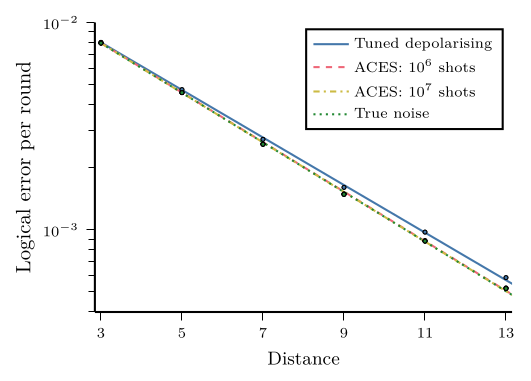

In [6]:
# Plot the logical error rates
dist_min = minimum(dist_set)
dist_max = maximum(dist_set)
dist_dense = collect(dist_min:0.1:dist_max+1)
decoder_order = [2; 3; 4; 1]
aces_decoding_plot = plot(;
    xticks=dist_set, xlims=(dist_min, dist_max), xwiden=1.03,
    xminorticks=0, xguide="Distance",
    yticks=[0.0001; 0.001; 0.01], ylims=(3.999e-4, 1e-2),
    yminorticks=9, yguide="Logical error per round", yaxis=:log,
    minorgridalpha=0.0, minorgrid=true,
    legend=:topright, size=(col_width_px, col_height_px),
    extra_kwargs=Dict(:subplot => Dict("ylabel style" => "at={(ticklabel cs:0.5,-10)}, anchor={near ticklabel},")))
for decoder_idx in decoder_order
    # Plot the data points with error bars
    scatter!(dist_set, dist_errors[:, decoder_idx];
        yerr=dist_errors_se[:, decoder_idx],
        label=nothing, color=colour_series[decoder_idx],
        marker=:circle, markersize=1.25, markerstrokewidth=0.5)
    # Plot larger data points without error bars
    scatter!(dist_set, dist_errors[:, decoder_idx];
        label=nothing, color=colour_series[decoder_idx],
        marker=:circle, markersize=1.25, markerstrokewidth=0.25)
    # Plot the fit line
    plot!(dist_dense, exp.(dist_linear_model(dist_dense, dist_fit_params[decoder_idx, :]));
        label=decoder_plot_labels[decoder_idx], color=colour_series[decoder_idx],
        linestyle=linestyle_set[decoder_idx])
end
savefig(aces_decoding_plot, "figures/aces_decoding_plot.pdf")
display(aces_decoding_plot)

In [7]:
# Estimate the memory error ratios
ratio_idx = 1
ratio_indices = setdiff(collect(1:decoder_num), ratio_idx)
dist_x_errors_cov = cov.(rounds_x_errors_set; dims=1) ./ seed_num_set
dist_z_errors_cov = cov.(rounds_z_errors_set; dims=1) ./ seed_num_set
dist_x_ratios = dist_x_errors ./ dist_x_errors[:, ratio_idx]
dist_z_ratios = dist_z_errors ./ dist_z_errors[:, ratio_idx]
dist_x_ratios_se = Matrix{Float64}(undef, dist_num, decoder_num)
dist_z_ratios_se = Matrix{Float64}(undef, dist_num, decoder_num)
for dist_idx in 1:dist_num
    for decoder_idx in 1:decoder_num
        # Memory X error ratio
        dist_x_ratio = dist_x_ratios[dist_idx, decoder_idx]
        dist_x_top = dist_x_errors[dist_idx, decoder_idx]
        dist_x_bottom = dist_x_errors[dist_idx, ratio_idx]
        @assert dist_x_ratio ≈ dist_x_top / dist_x_bottom
        # Memory X error ratio standard error
        dist_x_top_var = dist_x_errors_cov[dist_idx][decoder_idx, decoder_idx]
        dist_x_bottom_var = dist_x_errors_cov[dist_idx][ratio_idx, ratio_idx]
        dist_x_ratio_cov = dist_x_errors_cov[dist_idx][decoder_idx, ratio_idx]
        dist_x_ratio_se = dist_x_ratio * sqrt(
            dist_x_top_var / dist_x_top^2 + dist_x_bottom_var / dist_x_bottom^2
            -
            2 * dist_x_ratio_cov / (dist_x_top * dist_x_bottom))
        dist_x_ratios_se[dist_idx, decoder_idx] = dist_x_ratio_se
        # Memory Z error ratio
        dist_z_ratio = dist_z_ratios[dist_idx, decoder_idx]
        dist_z_top = dist_z_errors[dist_idx, decoder_idx]
        dist_z_bottom = dist_z_errors[dist_idx, ratio_idx]
        @assert dist_z_ratio ≈ dist_z_top / dist_z_bottom
        # Memory Z error ratio standard error
        dist_z_top_var = dist_z_errors_cov[dist_idx][decoder_idx, decoder_idx]
        dist_z_bottom_var = dist_z_errors_cov[dist_idx][ratio_idx, ratio_idx]
        dist_z_ratio_cov = dist_z_errors_cov[dist_idx][decoder_idx, ratio_idx]
        dist_z_ratio_se = dist_z_ratio * sqrt(
            dist_z_top_var / dist_z_top^2 + dist_z_bottom_var / dist_z_bottom^2
            -
            2 * dist_z_ratio_cov / (dist_z_top * dist_z_bottom))
        dist_z_ratios_se[dist_idx, decoder_idx] = dist_z_ratio_se
    end
end

In [8]:
# Average the memory error ratios
dist_ratios = (dist_x_ratios + dist_z_ratios) / 2
dist_ratios_se = sqrt.(dist_x_ratios_se .^ 2 + dist_z_ratios_se .^ 2) / 2;
# Print the memory error ratios
digits = 4
dist_ratios_string = [
    "($(round.(dist_ratios[i, j], digits = digits)) ± $(round(dist_ratios_se[i, j], digits = digits)))%"
    for i in 1:dist_num, j in 1:decoder_num
]
pretty_table(hcat(dist_set, dist_ratios_string),
    header=["Distance"; decoder_labels],
    alignment=:l,
)

┌──────────┬──────────────┬────────────────────┬────────────────────┬────────────────────┐
│ Distance │ True noise   │ Tuned depolarising │ ACES: 10^6 shots   │ ACES: 10^7 shots   │
├──────────┼──────────────┼────────────────────┼────────────────────┼────────────────────┤
│ 3        │ (1.0 ± 0.0)% │ (1.0083 ± 0.0005)% │ (1.0022 ± 0.0003)% │ (1.0001 ± 0.0001)% │
│ 5        │ (1.0 ± 0.0)% │ (1.0347 ± 0.0009)% │ (1.0027 ± 0.0002)% │ (1.0002 ± 0.0001)% │
│ 7        │ (1.0 ± 0.0)% │ (1.0564 ± 0.0013)% │ (1.0034 ± 0.0003)% │ (1.0002 ± 0.0002)% │
│ 9        │ (1.0 ± 0.0)% │ (1.0806 ± 0.002)%  │ (1.0052 ± 0.0004)% │ (1.0003 ± 0.0002)% │
│ 11       │ (1.0 ± 0.0)% │ (1.1055 ± 0.0027)% │ (1.0057 ± 0.0007)% │ (1.0008 ± 0.0004)% │
│ 13       │ (1.0 ± 0.0)% │ (1.1287 ± 0.0027)% │ (1.006 ± 0.001)%   │ (1.0007 ± 0.0006)% │
└──────────┴──────────────┴────────────────────┴────────────────────┴────────────────────┘


In [9]:
# Estimate the error suppression factor ratios
dist_ratio_params = Matrix{Float64}(undef, decoder_num, 2)
dist_ratio_params_cov = Vector{Matrix{Float64}}(undef, decoder_num)
dist_ratio_suppression = Vector{Float64}(undef, decoder_num)
dist_ratio_suppression_se = Vector{Float64}(undef, decoder_num)
dist_ratio_params[ratio_idx, :] = zeros(2)
dist_ratio_params_cov[ratio_idx] = zeros(2, 2)
dist_ratio_suppression[ratio_idx] = 1.0
dist_ratio_suppression_se[ratio_idx] = 0.0
for decoder_idx in ratio_indices
    (dist_params, dist_params_cov) = fit_dist_error(dist_set, dist_ratios[:, decoder_idx], dist_ratios_se[:, decoder_idx]; return_cov=true)
    dist_ratio_params[decoder_idx, :] = dist_params
    dist_ratio_params_cov[decoder_idx] = dist_params_cov
    (error_suppression, error_suppression_se) = get_dist_error(dist_params, dist_params_cov)
    dist_ratio_suppression[decoder_idx] = error_suppression
    dist_ratio_suppression_se[decoder_idx] = error_suppression_se
end
# Print the error suppression factors
digits = 4
dist_inverse_ratio_suppression_string = [
    "$(round(1/dist_ratio_suppression[j], digits = digits)) ± $(round(dist_ratio_suppression_se[j]/dist_ratio_suppression[j]^2, digits = digits))"
    for j in 1:decoder_num
]
pretty_table(hcat(decoder_labels, dist_inverse_ratio_suppression_string),
    header=["Decoder"; "Inverse Lambda ratio"],
    alignment=:l,
)

┌────────────────────┬──────────────────────┐
│ Decoder            │ Inverse Lambda ratio │
├────────────────────┼──────────────────────┤
│ True noise         │ 1.0 ± 0.0            │
│ Tuned depolarising │ 1.0233 ± 0.0003      │
│ ACES: 10^6 shots   │ 1.0009 ± 0.0001      │
│ ACES: 10^7 shots   │ 1.0001 ± 0.0001      │
└────────────────────┴──────────────────────┘


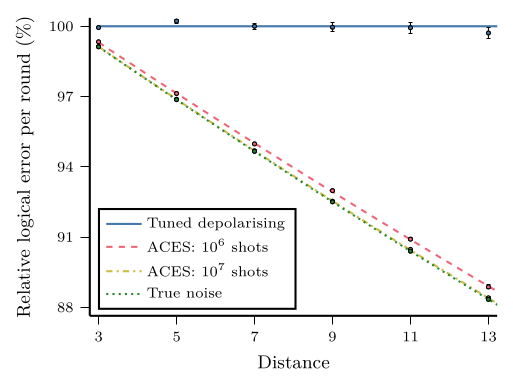

In [10]:
# Plot the logical error rate ratios
y_min = 88
y_int = 3
y_max = 100
comparison_idx = 2
comparison_line = exp.(dist_linear_model(dist_dense, dist_ratio_params[comparison_idx, :]))
comparison_vals = exp.(dist_linear_model(dist_set, dist_ratio_params[comparison_idx, :]))
@assert ratio_idx == 1
decoder_order = [2; 3; 4; 1]
aces_ratio_plot = plot(;
    xticks=dist_set, xlims=(dist_min, dist_max), xwiden=1.045,
    yticks=y_min:y_int:y_max, ylims=(y_min, y_max), ywiden=1.06,
    xguide="Distance", yguide="Relative logical error per round (%)",
    legend=:bottomleft, size=(0.9809 * col_width_px, 1.0220 * col_height_px))
for decoder_idx in decoder_order
    dist_ratio = dist_ratios[:, decoder_idx]
    dist_ratio_se = dist_ratios_se[:, decoder_idx]
    # Plot the data points with error bars
    scatter!(dist_set, 100 * (dist_ratio ./ comparison_vals);
        yerr=100 * (dist_ratio_se ./ comparison_vals),
        label=nothing, color=colour_series[decoder_idx],
        marker=:circle, markersize=1.25, markerstrokewidth=0.5)
    # Plot larger data points without error bars
    scatter!(dist_set, 100 * (dist_ratio ./ comparison_vals);
        label=nothing, color=colour_series[decoder_idx],
        marker=:circle, markersize=1.25, markerstrokewidth=0.25)
    # Plot the fit line
    decoder_fit_line = exp.(dist_linear_model(dist_dense, dist_ratio_params[decoder_idx, :]))
    plot!(dist_dense, 100 * (decoder_fit_line ./ comparison_line);
        label=decoder_plot_labels[decoder_idx], color=colour_series[decoder_idx],
        linestyle=linestyle_set[decoder_idx])
end
savefig(aces_ratio_plot, "figures/aces_ratio_plot.pdf")
display(aces_ratio_plot)

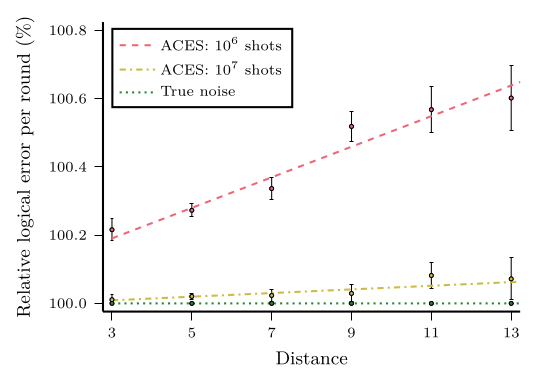

In [11]:
# Plot zoomed in logical error rate ratios
y_min = 100
y_int = 0.2
y_max = 100.8
@assert ratio_idx == 1
decoder_order = [3; 4; 1]
aces_small_ratio_plot = plot(;
    xticks=dist_set, xlims=(dist_min, dist_max), xwiden=1.045,
    yticks=y_min:y_int:y_max, ylims=(y_min, y_max), ywiden=1.06,
    xguide="Distance", yguide="Relative logical error per round (%)",
    legend=:topleft, size=(col_width_px, col_height_px))
for decoder_idx in decoder_order
    dist_ratio = dist_ratios[:, decoder_idx]
    dist_ratio_se = dist_ratios_se[:, decoder_idx]
    # Plot the data points with error bars
    scatter!(dist_set, 100 * dist_ratio;
        yerr=100 * dist_ratio_se,
        label=nothing, color=colour_series[decoder_idx],
        marker=:circle, markersize=1.25, markerstrokewidth=0.5)
    # Plot larger data points without error bars
    scatter!(dist_set, 100 * dist_ratio;
        label=nothing, color=colour_series[decoder_idx],
        marker=:circle, markersize=1.25, markerstrokewidth=0.25)
    # Plot the fit line
    decoder_fit_line = exp.(dist_linear_model(dist_dense, dist_ratio_params[decoder_idx, :]))
    plot!(dist_dense, 100 * decoder_fit_line;
        label=decoder_plot_labels[decoder_idx], color=colour_series[decoder_idx],
        linestyle=linestyle_set[decoder_idx])
end
savefig(aces_small_ratio_plot, "figures/aces_small_ratio_plot.pdf")
display(aces_small_ratio_plot)

In [12]:
# Extrapolate the logical error rate ratios to distance 25
dist_1 = 25
dist_1_ratio_extrapolations = [exp(dist_linear_model(dist_1, dist_ratio_params[decoder_idx, :])) for decoder_idx in 1:decoder_num]
dist_1_ratio_extrapolations_se = dist_1_ratio_extrapolations .* [sqrt([dist_1; 1]' * dist_ratio_params_cov[decoder_idx] * [dist_1; 1]) for decoder_idx in 1:decoder_num]
# Print the extrapolated logical error rate ratios
digits = 4
dist_1_ratio_extrapolations_string = [
    "$(round(dist_1_ratio_extrapolations[j], digits = digits)) ± $(round(dist_1_ratio_extrapolations_se[j], digits = digits))"
    for j in 1:decoder_num
]
pretty_table(hcat(decoder_labels, dist_1_ratio_extrapolations_string),
    header=["Decoder"; "Distance $(dist_1) relative LER per round"],
    alignment=:l,
)

┌────────────────────┬────────────────────────────────────┐
│ Decoder            │ Distance 25 relative LER per round │
├────────────────────┼────────────────────────────────────┤
│ True noise         │ 1.0 ± 0.0                          │
│ Tuned depolarising │ 1.2997 ± 0.0043                    │
│ ACES: 10^6 shots   │ 1.0118 ± 0.0012                    │
│ ACES: 10^7 shots   │ 1.0013 ± 0.0006                    │
└────────────────────┴────────────────────────────────────┘


In [13]:
# Extrapolate the logical error rates to distance 61
dist_2 = 61
dist_2_error_extrapolations = [exp(dist_linear_model(dist_2, dist_fit_params[decoder_idx, :])) for decoder_idx in 1:decoder_num]
dist_2_error_extrapolations_se = dist_2_error_extrapolations .* [[dist_2; 1]' * dist_fit_params_cov[decoder_idx] * [dist_2; 1] for decoder_idx in 1:decoder_num]
# Extrapolate the logical error rates to distance 63
dist_3 = 63
dist_3_error_extrapolations = [exp(dist_linear_model(dist_3, dist_fit_params[decoder_idx, :])) for decoder_idx in 1:decoder_num]
dist_3_error_extrapolations_se = dist_3_error_extrapolations .* [[dist_3; 1]' * dist_fit_params_cov[decoder_idx] * [dist_3; 1] for decoder_idx in 1:decoder_num]
# Print the extrapolated logical error rates
scale_factor = 10
digits = 3
dist_2_error_string = [
    "($(round(10^scale_factor * dist_2_error_extrapolations[j], digits = digits)) ± $(round(10^scale_factor * dist_2_error_extrapolations_se[j], digits = digits))) x 1e$(-scale_factor)"
    for j in 1:decoder_num
]
dist_3_error_string = [
    "($(round(10^scale_factor * dist_3_error_extrapolations[j], digits = digits)) ± $(round(10^scale_factor * dist_3_error_extrapolations_se[j], digits = digits))) x 1e$(-scale_factor)"
    for j in 1:decoder_num
]
pretty_table(hcat(decoder_labels, dist_2_error_string, dist_3_error_string),
    header=["Decoder"; "Distance $(dist_2) LER per round"; "Distance $(dist_3) LER per round"],
    alignment=:l,
)
n_1 = 2 * dist_2^2 - 1
n_3 = 2 * dist_3^2 - 1
println("Distance $(dist_2): qubit count $(n_1).")
println("Distance $(dist_3): qubit count $(n_3).")
println("This is an absolute qubit difference of $(n_3-n_1), and a relative difference of $(round(100 * (n_3-n_1)/n_3, digits=digits))%.")

┌────────────────────┬───────────────────────────┬───────────────────────────┐
│ Decoder            │ Distance 61 LER per round │ Distance 63 LER per round │
├────────────────────┼───────────────────────────┼───────────────────────────┤
│ True noise         │ (8.973 ± 0.014) x 1e-10   │ (5.169 ± 0.009) x 1e-10   │
│ Tuned depolarising │ (17.597 ± 0.031) x 1e-10  │ (10.372 ± 0.019) x 1e-10  │
│ ACES: 10^6 shots   │ (9.187 ± 0.015) x 1e-10   │ (5.296 ± 0.009) x 1e-10   │
│ ACES: 10^7 shots   │ (9.009 ± 0.014) x 1e-10   │ (5.19 ± 0.009) x 1e-10    │
└────────────────────┴───────────────────────────┴───────────────────────────┘
Distance 61: qubit count 7441.
Distance 63: qubit count 7937.
This is an absolute qubit difference of 496, and a relative difference of 6.249%.
